# Data pre-processing

## TODOs longterm:
* include the different product types which are relevant for mode shift

In [19]:
# case setting 
case = 1 # 1, 2, 3, 4

Rules: network_cost, elec_price
Case 1: const, const
Case 2: diff, const
Case 3: const, diff
Case 4: diff, diff

In [20]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

from pyproj import Geod

In [21]:
# Nuts regions 
nuts_regions = gpd.read_file("data/NUTS_RG_20M_2021_4326.shp/NUTS_RG_20M_2021_4326.shp")
print(nuts_regions.keys())

Index(['NUTS_ID', 'LEVL_CODE', 'CNTR_CODE', 'NAME_LATN', 'NUTS_NAME',
       'MOUNT_TYPE', 'URBN_TYPE', 'COAST_TYPE', 'geometry'],
      dtype='object')


## Step 1: Definition of regions within SM corridor

In [22]:
# loading the dataset 
nuts_3_to_nodes = pd.read_csv("data/Trucktraffic/02_NUTS-3-Regions.csv")

# filter rule 
nuts_to_filter_for = { "NUTS_0": ["DE", "DK"],
                        "NUTS_1": ["SE1", "SE2", "AT3", "ITC", "ITH", "ITI", "ITF"],
                      "NUTS_2": ["SE11", "SE12", "SE21", "SE22", "NO08", "NO09","NO02", "NO0A"],}

## Step 2: Filtering route set for relevant routes

In [23]:
for level, nuts_list in nuts_to_filter_for.items():
    missing = [nuts for nuts in nuts_list if nuts not in nuts_regions['NUTS_ID'].values]
    print(f"Missing {level} codes in NUTS_ID: {missing}")

Missing NUTS_0 codes in NUTS_ID: []
Missing NUTS_1 codes in NUTS_ID: []
Missing NUTS_2 codes in NUTS_ID: []


In [24]:
from shapely import wkt

# Filter nuts_regions for the selected NUTS_2 codes
filtered_nodes_by_level = {}

# Convert nuts_3_to_nodes to a GeoDataFrame if not already done
if 'nuts_3_to_nodes_gdf' not in locals():
    nuts_3_to_nodes_gdf = gpd.GeoDataFrame(
        nuts_3_to_nodes,
        geometry=nuts_3_to_nodes['Geometric_center'].apply(wkt.loads),
        crs=nuts_regions.crs
    )

for level, nuts_list in nuts_to_filter_for.items():
    selected_polygons = nuts_regions[nuts_regions['NUTS_ID'].isin(nuts_list)]
    filtered_nodes = gpd.sjoin(nuts_3_to_nodes_gdf, selected_polygons, predicate='within')
    filtered_nodes_by_level[level] = filtered_nodes

# Show the filtered nodes for each level
# for level, df in filtered_nodes_by_level.items():
#     print(f"Filtered nodes for {level}:")
#     print(df)

# Concatenate all filtered nodes into a single GeoDataFrame
all_filtered_nodes = gpd.GeoDataFrame(
    pd.concat(filtered_nodes_by_level.values(), ignore_index=True),
    crs=nuts_3_to_nodes_gdf.crs
)
print(len(all_filtered_nodes))

585


In [25]:
network_nodes = pd.read_csv("data/Trucktraffic/03_network-nodes.csv")
network_edges = pd.read_csv("data/Trucktraffic/04_network-edges.csv")


# Filter network_nodes for ETISplus_Zone_ID values present in all_filtered_nodes
filtered_network_nodes = network_nodes[network_nodes['ETISplus_Zone_ID'].isin(all_filtered_nodes['ETISPlus_Zone_ID'])]

print(filtered_network_nodes.head())
print(len(filtered_network_nodes))

filtered_node_ids = set(filtered_network_nodes['Network_Node_ID'])
filtered_network_edges = network_edges[
    network_edges['Network_Node_A_ID'].isin(filtered_node_ids) &
    network_edges['Network_Node_B_ID'].isin(filtered_node_ids)
]

print(filtered_network_edges.head())
print(len(filtered_network_edges))


      Unnamed: 0  Network_Node_ID  Network_Node_X  Network_Node_Y  \
1772        1772           180700        7.528817       43.788883   
3160        3160           115859        8.323819       51.854465   
3161        3161           261011        8.222161       51.828710   
3162        3162           196681        8.276247       53.136547   
3163        3163           115672        8.273000       53.113300   

      ETISplus_Zone_ID Country  
1772         118120301      IT  
3160         107100402      DE  
3161         107100402      DE  
3162         107090403      DE  
3163         107090403      DE  
4621
    Unnamed: 0  Network_Edge_ID  Manually_Added  Distance  Network_Node_A_ID  \
17          17          2610360               0     1.566             262892   
18          18          2610359               0     1.548             262891   
19          19          1030375               0     2.053             262891   
20          20          1024240               0     4.708     

In [26]:
truck_traffic = pd.read_csv("data/Trucktraffic/01_Trucktrafficflow.csv")
# Convert the string representation of lists to actual lists of integers
truck_traffic['Edge_path_E_road'] = truck_traffic['Edge_path_E_road'].apply(lambda x: [int(i) for i in x.strip('[]').split(',') if i.strip().isdigit()])

# Get the set of filtered Network_Edge_IDs
filtered_edge_ids = set(filtered_network_edges['Network_Edge_ID'])

# Keep only rows where all edges in Edge_path_E_road are in filtered_edge_ids
def all_edges_in_filtered(edge_list):
    return all(e in filtered_edge_ids for e in edge_list)

filtered_truck_traffic = truck_traffic[truck_traffic['Edge_path_E_road'].apply(all_edges_in_filtered)].copy()

In [27]:
print(len(filtered_truck_traffic))
print(filtered_truck_traffic.head())

189435
       Unnamed: 0  ID_origin_region Name_origin_region  ID_destination_region  \
25157       25157         101030101         Innviertel              101030102   
25158       25158         101030101         Innviertel              101030103   
25159       25159         101030101         Innviertel              101030104   
25160       25160         101030101         Innviertel              101030105   
25162       25162         101030101         Innviertel              101030202   

      Name_destination_region  \
25157               Linz-Wels   
25158             Muhlviertel   
25159         Steyr-Kirchdorf   
25160            Traunviertel   
25162          Pinzgau-Pongau   

                                        Edge_path_E_road  \
25157  [1009124, 1301181, 1009111, 1009116, 1201209, ...   
25158  [2608161, 1310457, 1009153, 1009150, 2608159, ...   
25159  [1030253, 1035167, 1035166, 1009156, 1000138, ...   
25160  [1009187, 2608115, 1009175, 1000137, 2608135, ...   
25162  

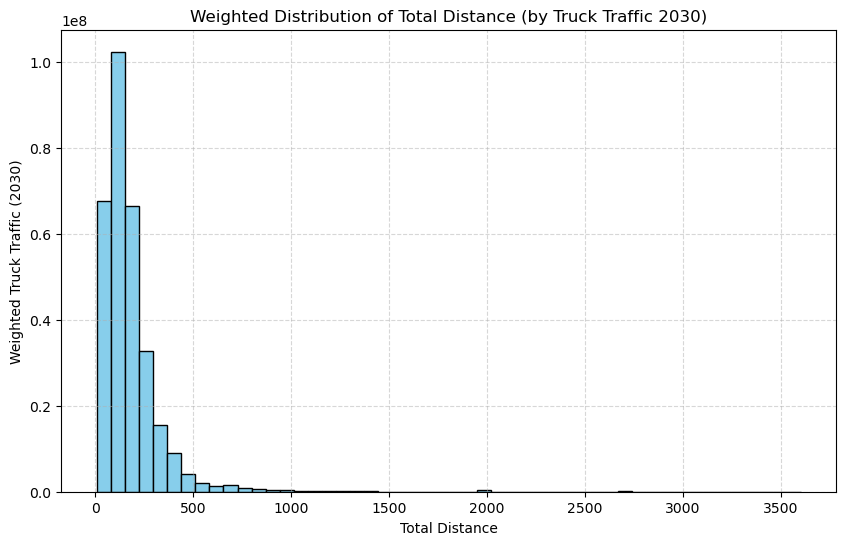

Average: 603.73, Min: 8.00, Max: 3604.00


In [28]:
plt.figure(figsize=(10, 6))
plt.hist(
    filtered_truck_traffic['Total_distance'],
    bins=50,
    weights=filtered_truck_traffic['Traffic_flow_trucks_2030'],
    color='skyblue',
    edgecolor='black'
)
plt.xlabel('Total Distance')
plt.ylabel('Weighted Truck Traffic (2030)')
plt.title('Weighted Distribution of Total Distance (by Truck Traffic 2030)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()
avg = filtered_truck_traffic['Total_distance'].mean()
min_val = filtered_truck_traffic['Total_distance'].min()
max_val = filtered_truck_traffic['Total_distance'].max()
print(f"Average: {avg:.2f}, Min: {min_val:.2f}, Max: {max_val:.2f}")

## Step 3: Mapping to relevant NUTS-2 regions

substeps:
3.1 getting relevant NUTS-2 regions -- check
3.2 cutting routes to relevant regions 
3.3 mapping from NUTS-3 to NUTS-2 

### Step 3.2.: getting relevant NUTS-2 regions

In [29]:
print(nuts_regions.keys())

Index(['NUTS_ID', 'LEVL_CODE', 'CNTR_CODE', 'NAME_LATN', 'NUTS_NAME',
       'MOUNT_TYPE', 'URBN_TYPE', 'COAST_TYPE', 'geometry'],
      dtype='object')


In [30]:
# Collect all relevant NUTS_IDs from nuts_to_filter_for
relevant_codes = []
for codes in nuts_to_filter_for.values():
    relevant_codes.extend(codes)

# Filter nuts_regions for LEVL_CODE == 2 and NUTS_ID containing any relevant code
mask = (nuts_regions['LEVL_CODE'] == 3) & (
    nuts_regions['NUTS_ID'].apply(lambda x: any(code in x for code in relevant_codes))
)
relevant_nuts_regions = nuts_regions[mask]
print(relevant_nuts_regions[['NUTS_ID', 'NUTS_NAME']])

     NUTS_ID                    NUTS_NAME
322    DE254   Nürnberg, Kreisfreie Stadt
323    DE255  Schwabach, Kreisfreie Stadt
324    DE256           Ansbach, Landkreis
325    DE257           Erlangen-Höchstadt
402    DE258             Fürth, Landkreis
...      ...                          ...
1668   SE212               Kronobergs län
1669   SE213                   Kalmar län
1670   SE214                 Gotlands län
1671   SE221                 Blekinge län
1672   SE224                    Skåne län

[542 rows x 2 columns]


In [31]:
# Create a mapping from Network_Edge_ID to Distance for filtered_network_edges
edge_distance_map = dict(zip(filtered_network_edges['Network_Edge_ID'], filtered_network_edges['Distance']))

def reduce_route_and_distance(edge_list):
    # Keep only edges that are in filtered_edge_ids
    reduced_route = [e for e in edge_list if e in filtered_edge_ids]
    # Calculate the total distance for the reduced route
    reduced_distance = sum(edge_distance_map.get(e, 0) for e in reduced_route)
    return pd.Series({'Reduced_Edge_path': reduced_route, 'Reduced_Distance': reduced_distance})

# Apply the function to filtered_truck_traffic
filtered_truck_traffic[['Reduced_Edge_path', 'Reduced_Distance']] = filtered_truck_traffic['Edge_path_E_road'].apply(reduce_route_and_distance)

# Show a sample of the new columns
filtered_truck_traffic[['Edge_path_E_road', 'Reduced_Edge_path', 'Reduced_Distance']].head()     


,Edge_path_E_road,Reduced_Edge_path,Reduced_Distance
25157,"[1009124, 1301181, 1009111, 1009116, 1201209, ...","[1009124, 1301181, 1009111, 1009116, 1201209, ...",67.165
25158,"[2608161, 1310457, 1009153, 1009150, 2608159, ...","[2608161, 1310457, 1009153, 1009150, 2608159, ...",120.808
25159,"[1030253, 1035167, 1035166, 1009156, 1000138, ...","[1030253, 1035167, 1035166, 1009156, 1000138, ...",119.134
25160,"[1009187, 2608115, 1009175, 1000137, 2608135, ...","[1009187, 2608115, 1009175, 1000137, 2608135, ...",98.896
25162,"[1009213, 1301148, 1009238, 1000160, 1009241, ...","[1009213, 1301148, 1009238, 1000160, 1009241, ...",214.832


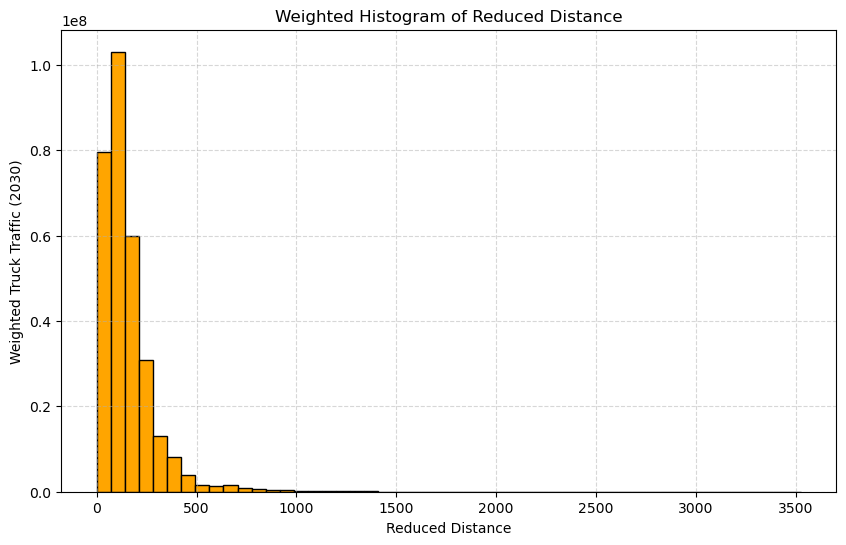

189435


In [32]:
plt.figure(figsize=(10, 6))
plt.hist(
    filtered_truck_traffic['Reduced_Distance'],
    bins=50,
    weights=filtered_truck_traffic['Traffic_flow_trucks_2030'],
    color='orange',
    edgecolor='black'
)
plt.xlabel('Reduced Distance')
plt.ylabel('Weighted Truck Traffic (2030)')
plt.title('Weighted Histogram of Reduced Distance')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()
print(len(filtered_truck_traffic))                                                                                                                                                        

__What do I need as input data?__

* TechVehicle (check)
* VehicleType (check)
* Modes(check)
* Technology (check)
* Fuel (check)
* Product types (check)
* Regiontype (check)
* Speed (check)
* InititalModeInfr (check)
* InititalFuelingInfr (check)
* Odpair (check)
* Path (check)
* GeographicElement (check)
* Model Params
* InititalVehicleStock (check) 
* FinancialStatus (only one indicating frequency of new purchases) (check)
* MaximumFuelingCapacityByType 
* FuelingInfrTypes (check)
* MaximumFuelingCapacityByTypeByYear

In [33]:
Y = 41
G = 25
y_init = 2020


### Preparing demand side parameters

Main assumptions:
* electrification of interregional road freight is currently 0 
* current assumption: constant transport demand values for road freight
* long-haul is: > 350km

In [34]:
long_haul_truck_traffic = filtered_truck_traffic[filtered_truck_traffic['Reduced_Distance'] >= 350].copy()
print(len(long_haul_truck_traffic))
long_haul_truck_traffic.head()

112926


,Unnamed: 0,ID_origin_region,Name_origin_region,ID_destination_region,Name_destination_region,Edge_path_E_road,Distance_from_origin_region_to_E_road,Distance_within_E_road,Distance_from_E_road_to_destination_region,Total_distance,Traffic_flow_trucks_2010,Traffic_flow_trucks_2019,Traffic_flow_trucks_2030,Traffic_flow_tons_2010,Traffic_flow_tons_2019,Traffic_flow_tons_2030,Reduced_Edge_path,Reduced_Distance
25167,25167,101030101,Innviertel,101030304,Tiroler Oberland,"[1035224, 1035023, 1035070, 1035211, 1310530, ...",5.0,362.0,4.0,371.0,1815.00,1880.0,1963.75,24684.0,25568.0,26707.0,"[1035224, 1035023, 1035070, 1035211, 1310530, ...",361.895
25169,25169,101030101,Innviertel,101030401,Bludenz-Bregenzer Wald,"[1310379, 1310376, 1035214, 1035215, 1035213, ...",5.0,404.0,4.0,413.0,345.00,357.5,373.75,4692.0,4862.0,5083.0,"[1310379, 1310376, 1035214, 1035215, 1035213, ...",403.778
25170,25170,101030101,Innviertel,101030402,Rheintal-Bodenseegebiet,"[1035659, 1310419, 1310408, 1009404, 1301152, ...",5.0,355.0,8.0,368.0,1466.25,1520.0,1586.25,19941.0,20672.0,21573.0,"[1035659, 1310419, 1310408, 1009404, 1301152, ...",355.116
25280,25280,101030101,Innviertel,107010101,"Stuttgart, Stadtkreis","[1010268, 1300644, 1010280, 1010353, 1000437, ...",5.0,360.0,8.0,373.0,315.00,417.5,588.75,4284.0,5678.0,8007.0,"[1010268, 1300644, 1010280, 1010353, 1000437, ...",359.823
25281,25281,101030101,Innviertel,107010102,Boblingen,"[1010327, 1010307, 1010322, 1300586, 1010266, ...",5.0,377.0,1.0,383.0,203.75,270.0,381.25,2771.0,3672.0,5185.0,"[1010327, 1010307, 1010322, 1300586, 1010266, ...",377.139


In [35]:
import numpy as np

carbon_price = {2018: 15.06, 2020: 30, 2025: 51.5871, 2030: 76.4254, 2035: 113.223, 2040: 167.737, 2045:248.5, 2050: 355}


def interpolate_carbon_price(year, carbon_price_dict):
    """
    Interpolates the carbon price for a given year based on a dictionary of defined values.

    :param year: The year for which to interpolate the carbon price.
    :param carbon_price_dict: A dictionary with years as keys and carbon prices as values.
    :return: The interpolated carbon price for the given year.
    """
    years = np.array(list(carbon_price_dict.keys()))
    prices = np.array(list(carbon_price_dict.values()))
    
    if year < years.min():
        # Extrapolate for years before the minimum defined year
        slope = (prices[1] - prices[0]) / (years[1] - years[0])
        return prices[0] + slope * (year - years[0])
    elif year > years.max():
        # Extrapolate for years after the maximum defined year
        slope = (prices[-1] - prices[-2]) / (years[-1] - years[-2])
        return prices[-1] + slope * (year - years[-1])
    else:
        # Interpolate for years within the defined range
        return np.interp(year, years, prices)

# Example usage
print(interpolate_carbon_price(2023, carbon_price))
carbon_price_dict = {year: interpolate_carbon_price(year, carbon_price) for year in range(2020, 2062)}

42.95226


In [36]:
# creating geographic_elements 
geographic_elements = []
nuts3_to_geo_id_map = {}
id_geo = 0

for index, row in filtered_network_nodes.iterrows():
    geographic_elements.append({
        "id": id_geo,
        "type": "node",
        "name": row['ETISplus_Zone_ID'],
        "carbon_price": [float(carbon_price_dict[year+y_init]) for year in range(Y)],
        "from": 999999,
        "to": 999999,
        "length": 0.0,
    })
    # 
    # nuts3_to_geo_id_map[nuts3_id] = id_geo
    id_geo += 1

print(f"Number of geographic elements: {len(geographic_elements)}")

Number of geographic elements: 4621


In [ ]:
def map_nodes_to_nuts3_regions(network_node_ids, filtered_network_nodes, nuts3_to_geo_id_map):
    """
    Map network node IDs to GeographicElement IDs (NUTS-3 regions).

    Parameters:
    - network_node_ids: list of Network_Node_IDs
    - filtered_network_nodes: DataFrame with Network_Node_ID and ETISplus_Zone_ID columns
    - nuts3_to_geo_id_map: dict mapping NUTS-3 IDs to GeographicElement IDs

    Returns:
    - List of GeographicElement IDs representing NUTS-3 regions along the path
    """
    if not network_node_ids:
        return []

    # Map network nodes to their NUTS-3 regions
    nuts3_regions = []
    seen_regions = set()  # Track regions to avoid duplicates

    for node_id in network_node_ids:
        # Find the NUTS-3 region for this network node
        node_row = filtered_network_nodes[filtered_network_nodes["Network_Node_ID"] == node_id]
        if not node_row.empty:
            nuts3_id = node_row.iloc[0]["ETISplus_Zone_ID"]
            # Only add if we haven't seen this region yet (to avoid consecutive duplicates)
            if nuts3_id not in seen_regions or (nuts3_regions and nuts3_regions[-1] != nuts3_to_geo_id_map.get(nuts3_id)):
                if nuts3_id in nuts3_to_geo_id_map:
                    geo_id = nuts3_to_geo_id_map[nuts3_id]
                    # Avoid consecutive duplicates
                    if not nuts3_regions or nuts3_regions[-1] != geo_id:
                        nuts3_regions.append(geo_id)
                        seen_regions.add(nuts3_id)

    return nuts3_regions

print("Added map_nodes_to_nuts3_regions function")

In [ ]:
# Create mapping from NUTS-3 IDs (ETISplus_Zone_ID) to GeographicElement IDs
nuts3_to_geo_id_map = {geo["name"]: geo["id"] for geo in geographic_elements}
print(f"Created nuts3_to_geo_id_map with {len(nuts3_to_geo_id_map)} entries")

In [37]:
def get_nodes_along_path(edge_path, edge_df):
    """
    Returns a set of node IDs traversed along a path of edges.
    
    Parameters:
    - edge_path: list of Network_Edge_IDs representing the path
    - edge_df: DataFrame with edge data including 'Network_Edge_ID', 'Network_Node_A_ID', and 'Network_Node_B_ID'
    
    Returns:
    - Set of unique Network_Node_IDs along the path
    """
    if not edge_path:
        return set()

    # Pre-filter relevant edges and build a quick lookup dict
    path_edges_df = edge_df[edge_df['Network_Edge_ID'].isin(edge_path)]
    edge_map = {
        edge_id: (int(row['Network_Node_A_ID']), int(row['Network_Node_B_ID']))
        for edge_id, row in path_edges_df.set_index('Network_Edge_ID').iterrows()
    }

    if edge_path[0] not in edge_map:
        return set()

    node_a, node_b = edge_map[edge_path[0]]
    nodes = [node_a]
    current_node = node_a

    for edge_id in edge_path:
        if edge_id not in edge_map:
            continue
        a, b = edge_map[edge_id]
        if current_node == a:
            next_node = b
        elif current_node == b:
            next_node = a
        else:
            # If the edge doesn't connect properly, assume disconnected edge
            next_node = b
        nodes.append(next_node)
        current_node = next_node

    return set(nodes)
def sort_nodes_by_path_sequence(nodes_set, origin_id, destination_id, filtered_network_nodes):
    """
    Returns a list of node IDs (Network_Node_ID) sorted in the order they appear along the route,
    starting from the origin and ending at the destination.
    """
    # Filter only needed nodes for lookup
    relevant_nodes = filtered_network_nodes[
        filtered_network_nodes['Network_Node_ID'].isin(nodes_set)
    ].copy()

    if relevant_nodes.empty:
        return []

    # Get origin and destination coordinates
    origin_row = filtered_network_nodes[
        filtered_network_nodes['ETISplus_Zone_ID'] == origin_id
    ]
    dest_row = filtered_network_nodes[
        filtered_network_nodes['ETISplus_Zone_ID'] == destination_id
    ]
    if origin_row.empty or dest_row.empty:
        return list(nodes_set)  # fallback

    origin_coord = (
        origin_row.iloc[0]['Network_Node_X'],
        origin_row.iloc[0]['Network_Node_Y']
    )
    dest_coord = (
        dest_row.iloc[0]['Network_Node_X'],
        dest_row.iloc[0]['Network_Node_Y']
    )

    # Compute distances using geodesic inverse
    geod = Geod(ellps="WGS84")

    def compute_sort_key(row):
        _, _, dist_to_origin = geod.inv(origin_coord[0], origin_coord[1],
                                        row['Network_Node_X'], row['Network_Node_Y'])
        _, _, dist_to_dest = geod.inv(dest_coord[0], dest_coord[1],
                                      row['Network_Node_X'], row['Network_Node_Y'])
        return dist_to_origin - dist_to_dest

    relevant_nodes['sort_key'] = relevant_nodes.apply(compute_sort_key, axis=1)
    sorted_nodes = relevant_nodes.sort_values('sort_key')['Network_Node_ID'].tolist()

    return sorted_nodes

In [38]:
financial_status_list = [
    {   "id": 0,
        "name": "any",
        "VoT": [0.0] * Y,
        "monetary_budget_operational": 0.0,
        "monetary_budget_operational_lb": 0.0,
        "monetary_budget_operational_ub": 0.0,
        "monetary_budget_purchase": 0.0,
        "monetary_budget_purchase_lb": 0.0,
        "monetary_budget_purchase_ub": 0.0,
        "monetary_budget_purchase_time_horizon": 0.0,
        "average_household_size": 2.4,
     },
]


In [39]:
technologies = ["ICEV", "BEV"]

capital_cost_dict = {
    "ICEV": {2020: 110000, 2035: 110000, 2050: 110000},
    "BEV": {2020: 410000, 2035: 145000, 2050: 145000},
}
maintenance_annual_cost_dict = {
    "ICEV": {2020: 20000, 2035: 20000, 2050: 20000},
    "BEV": {2020: 14000, 2035: 14000, 2050: 14000},
}

fuel_economy_dict = {
    "ICEV": {2020: 2.90, 2035: 2.65, 2050: 2.4},  # in kWh/km
    "BEV": {2020: 1.44, 2035: 1.15, 2050: 1.05},  # in kWh/km
}

maintenance_distance_dict = {
    "ICEV": {2020: 0, 2035: 0, 2050: 0},  # in kWh/km
    "BEV": {2020: 0, 2035: 0, 2050: 0},  # in kWh/km
}


fuel_costs_dict = {
    "ICEV": {2020: 0, 2035: 0, 2050: 0},  # in kWh/km
    "BEV": {2020: 0, 2035: 0, 2050: 0},  # in kWh/km
}

battery_capacity_dict = {
    "ICEV": {2020: 5600, 2035: 5600, 2050: 5600},  # in kWh/km
    "BEV": {2020: 560, 2035: 1120, 2050: 1400},  # in kWh/km
}

peak_charging_dict = {
    "ICEV": {2020: 9999, 2035: 9999, 2050: 9999},  # in kWh/km
    "BEV": {2020: 350, 2035: 900, 2050: 1000},  # in kWh/km
}

occ = 13.6/26

W_dict = {
    "ICEV": {2020: 26 * occ, 2035: 26 * occ, 2050: 26 * occ},  # in kWh/km
    "BEV": {2020: 26 * occ * 0.75, 2035: 26 * occ * 0.9, 2050: 26 * occ},  # in kWh/km
}

annual_mileage_dict = {
    "ICEV": {2020: 120000, 2035: 120000, 2050: 120000},  # in km
    "BEV": {2020: 100000, 2035: 100000, 2050: 100000},  # in km
}


In [40]:
def extrapolate_years(known_values: dict, full_years: list) -> dict:
    """
    Linearly interpolate and extrapolate values for given years.
    
    Parameters:
    - known_values: dict of {year: value}
    - full_years: list of all years to cover (can include years outside known)
    
    Returns:
    - dict {year: value} for all years in full_years
    """
    from bisect import bisect_left

    known_years = sorted(known_values.keys())
    result = {}

    for y in sorted(full_years):
        if y in known_values:
            result[y] = known_values[y]
        elif y < known_years[0]:
            # Extrapolate before first known year
            y0, y1 = known_years[0], known_years[1]
            v0, v1 = known_values[y0], known_values[y1]
            slope = (v1 - v0) / (y1 - y0)
            result[y] = float(v0 + slope * (y - y0))
        elif y > known_years[-1]:
            # Extrapolate after last known year
            y0, y1 = known_years[-2], known_years[-1]
            v0, v1 = known_values[y0], known_values[y1]
            slope = (v1 - v0) / (y1 - y0)
            result[y] = float(v1 + slope * (y - y1))
        else:
            # Interpolate between closest known years
            idx = bisect_left(known_years, y)
            y0, y1 = known_years[idx - 1], known_years[idx]
            v0, v1 = known_values[y0], known_values[y1]
            t = (y - y0) / (y1 - y0)
            result[y] = float(v0 + t * (v1 - v0)
)
    return result


In [41]:
def scale_om_costs(original_main_costs, age):
    maintenance_costs = original_main_costs
    for y in range(4, age + 1):
        if y in [4, 5]:
            maintenance_costs = maintenance_costs * 1.05
        else:
            maintenance_costs = maintenance_costs * 1.1

    return maintenance_costs

In [42]:
tech_vehicle_list = []
tech_veh_id = 0

vehs = W_dict.keys()
years = range(y_init, y_init + Y)
generations = range(y_init-G, y_init + Y)
pre_y_init_generations = range(y_init - G, y_init)
print(pre_y_init_generations, y_init)
for tech in vehs:
    generation_dep_om_costs = extrapolate_years(maintenance_annual_cost_dict[tech], range(y_init, y_init + Y))
    generation_dep_om_costs.update({g: generation_dep_om_costs[y_init] for g in pre_y_init_generations})
    yearly_maintenance_costs = [[scale_om_costs(generation_dep_om_costs[g], age) for age in range(1, G+1)] for g in generations]    
    generation_dep_distance_om_costs = extrapolate_years(maintenance_distance_dict[tech], range(y_init, y_init + Y))
    generation_dep_distance_om_costs.update({g: generation_dep_distance_om_costs[y_init] for g in pre_y_init_generations})
    yearly_distance_maintenance_costs = [[scale_om_costs(generation_dep_distance_om_costs[g], age) for age in range(1, G+1)] for g in generations]
    extrapolated_fuel_economy = extrapolate_years(fuel_economy_dict[tech], years)
    extrapolated_W = extrapolate_years(W_dict[tech], years)
    extrapolated_tank_capacity = extrapolate_years(battery_capacity_dict[tech], years)
    extrapolated_peak_charging = extrapolate_years(peak_charging_dict[tech], years)
    if tech == "BEV":
        t = 0
    else:
        t = 1 
    tech_vehicle_list.append({
        "id": tech_veh_id,
        "name": tech,
        "capital_cost": [extrapolate_years(capital_cost_dict[tech], years)[y] for y in years],
        "maintenance_cost_annual": yearly_maintenance_costs,
        "maintenance_cost_distance": yearly_distance_maintenance_costs,
        "spec_cons": G * [extrapolated_fuel_economy[y_init]] + [extrapolated_fuel_economy[y] for y in years],
        "W": G * [extrapolated_W[y_init]] + [extrapolated_W[y] for y in years],
        "Lifetime": [G] * G,
        "AnnualRange": [120000] * G,
        "products": ["freight"],
        "tank_capacity": G * [extrapolated_tank_capacity[y_init]] + [extrapolated_tank_capacity[y] for y in years],
        "vehicle_type": "long-haul truck",
        "technology": t,
        "peak_fueling": G * [extrapolated_peak_charging[y_init]] + [extrapolated_peak_charging[y] for y in years],
        "fueling_time": G * [0.5] + [0.5] * Y,

    })

    tech_veh_id += 1

range(1995, 2020) 2020


In [43]:
from pyproj import Geod
initial_vehicle_stock = []
init_veh_stock_id = 0
odpair_list = []
path_list = []
odpair_id = 0
path_id = 0
total_rows = len(long_haul_truck_traffic)
progress_step = max(1, total_rows // 20)  # Print progress every 5%
max_od_id = 100
for idx, (index, row) in enumerate(long_haul_truck_traffic.iterrows()):
    if idx % progress_step == 0 or idx == total_rows - 1:
        print(f"Processing row {idx+1}/{total_rows} ({(idx+1)/total_rows:.1%})")
    F = row["Traffic_flow_trucks_2030"]
    path_etis = row["Reduced_Edge_path"]
    distance = row["Reduced_Distance"]
    nb_vehicles = F * ((distance)/(26*occ * 120000))
    vehicle_init_ids = []
    factor = 1/G
    for g in range(G):
        stock = nb_vehicles * factor
        initial_vehicle_stock.append({
            "id": init_veh_stock_id,
            "techvehicle": 1,
            "year_of_purchase": y_init - g,
            "stock": float(round(stock,2)),
        })
        vehicle_init_ids.append(init_veh_stock_id)
        init_veh_stock_id += 1

    nodes_in_route = get_nodes_along_path(row["Reduced_Edge_path"], filtered_network_edges)

    sorted_nodes = sort_nodes_by_path_sequence(
        nodes_in_route,
        row["ID_origin_region"],
        row["ID_destination_region"],
        filtered_network_nodes
    )
    
    # NEW: Convert network node IDs to GeographicElement IDs (NUTS-3 regions)
    geographic_sequence = map_nodes_to_nuts3_regions(
        sorted_nodes,
        filtered_network_nodes,
        nuts3_to_geo_id_map
    )
    
    # Convert NUTS-3 region IDs to strings
    origin_str = str(row["ID_origin_region"])
    destination_str = str(row["ID_destination_region"])
    
    odpair_list.append({
        "id": odpair_id,
        "from": origin_str,  # Use string NUTS-3 ID
        "to": destination_str,  # Use string NUTS-3 ID
        "F": [F] * Y,
        "product": "freight",
        "vehicle_stock_init": vehicle_init_ids, 
        "region_type": "interregional",
        "financial_status": "any",
        "travel_time_buget": 0.0,
        "purpose": "long-haul",

    })
    path_list.append({
        "id": path_id,
        "name": str(path_id),
        "length": row["Reduced_Distance"],
        "from": origin_str,  # Use string NUTS-3 ID
        "to": destination_str,  # Use string NUTS-3 ID
        "sequence": geographic_sequence,  # NOW CONTAINS GeographicElement IDs!
    })
    odpair_id += 1
    path_id += 1
    if odpair_id >= max_od_id:
        break

Processing row 1/112926 (0.0%)
[202005, 202000, 202004, 106643, 202002, 202001, 106658, 106663, 106640, 106646, 106638, 202003, 107893, 107892, 107898, 107895, 107891, 261101, 261100, 261099, 250180, 107889, 197201, 197200, 197197, 197196, 197195, 107919, 107954, 107955, 107956, 100637, 107953, 197184, 100638, 107855, 197180, 197179, 107850, 197187, 107854, 107883, 197178, 107911, 197168, 197162, 100663, 197160, 107946, 107948, 106750, 107944, 107945, 126300, 107947, 106751, 197158, 201902, 202011, 260837, 123480, 100214, 123478, 100213, 250227, 100238, 202012, 123641, 123640, 123639, 123643]
  sorted_nodes length: 71
  First 3 sorted_nodes: [202005, 202000, 202004]
    Node 202005 -> NUTS-3: 101030101 -> in map? False
    Node 202000 -> NUTS-3: 101030101 -> in map? False
    Node 202004 -> NUTS-3: 101030101 -> in map? False
    Node 106643 -> NUTS-3: 101030101 -> in map? False
    Node 202002 -> NUTS-3: 101030101 -> in map? False
  Total nodes in filtered_network_nodes: 4621
  Total N

In [44]:
vehicle_type_list = [{
    "id": 0,
    "name": "long-haul truck",
    "mode": 1, 
    "product": "freight",
}]

In [45]:
mode_list = [{
    "id": 1,
    "name": "road",
    "quantify_by_vehs": True,
    "costs_per_ukm": [0] * Y,
    "emission_factor": [699] * Y,
    "infrastructure_expansion_costs": [0.0] * Y,
    "infrastructure_om_costs": [0.1] * Y,
    "waiting_time": [0.0] * Y,
}]


### Geographic variation in connection costs and electricity prices

In [46]:
technology_list = [
    {
        "id": 0,
        "name": "ICEV",
        "fuel": "diesel",
    },
    {
        "id": 1,
        "name": "BEV",
        "fuel": "electricity",
    }
]

In [47]:
speed_list = [
    {
        "id": 0,
        "region_type": "highway",
        "travel_speed": 80,  # see in Shoman et al what their assumption is 
        "vehicle_type": "truck"
    }
]

region_list = [
    {
        "id": 0,
        "name": "highway",
        "costs_var": [0] * Y,
        "costs_fix": [0] * Y,
    }
]

In [48]:
initialmodeinfr = []
id = 0

for geo in geographic_elements:
    for m in mode_list:
        initialmodeinfr.append(
            {
                "id": len(initialmodeinfr),
                "mode": m["id"],
                "allocation": geo["id"],
                "installed_ukm": 0,
                "costs_per_ukm": [0.0] * Y,
            }
        )
        id += 1

In [49]:
initialfuelinfr = []

id_count = 0
for geo in geographic_elements:
    initialfuelinfr.append(
        {
            "id": id_count,
            "fuel": "electricity",
            "allocation": geo["id"],
            "installed_ukm": 0,
            "type": "charging_station",
        }
    )
    id_count += 1

for geo in geographic_elements:
    initialfuelinfr.append(
        {
            "id": id_count,
            "fuel": "diesel",
            "allocation": geo["id"],
            "installed_ukm": 900000,
            "type": "conventional_fueling_station",
        }
    )
    id_count += 1

In [50]:
charging_types_list = []

# TODO: differentiate between fast and overnight charging for trucks based on Shoman et al. (2023)
charging_types_list.append({
    "id": 0,
    "fueling_type": "charging_station",
    "fueling_power": [800] * Y,  # kW    # TODO: improving by year 
    "additional_fueling_time": False,
    "max_occupancy_rate_veh_per_year": 60,  # Use Shoman et al. (2023) assumption
    "by_route": False,
    "track_detour_time": False,
    "gamma": [(0.06 * 720/365)] * Y,
})

charging_types_list.append({
    "id": 1,
    "fueling_type": "conventional_fueling_station",
    "fueling_power": [10000] * Y,  # kW    # TODO: improving by year 
    "additional_fueling_time": False,
    "max_occupancy_rate_veh_per_year": 60,  # Use Shoman et al. (2023) assumption
    "by_route": False,
    "track_detour_time": False,
    "gamma": [(0.06 * 720/365)] * Y,
})

In [51]:
# TODO: connection costs for charging stations

conn_costs = pd.read_excel("data/electricity data/41467_2022_32835_MOESM4_ESM.xlsx", sheet_name="Main results", header=1)

In [52]:
print(conn_costs.keys())
print("Unique values in 'Country':", set(conn_costs["Country"].dropna()))
print("Unique values in 'Option':", set(conn_costs["Option"].dropna()))


Index(['Country', 'Option', 'CostEquipment', 'CostInstallation', 'CostOM',
       'ChargingEnergy', 'CostElectricityE', 'CostElectricityN',
       'CostElectricityT', 'Lifetime', 'InterestRate', 'CostTransaction',
       'Efficiency'],
      dtype='object')
Unique values in 'Country': {'Ireland', 'United Kingdom', 'Luxembourg', 'Portugal', 'Germany', 'Bulgaria', 'Croatia', 'Finland', 'Lithuania', 'Hungary', 'Austria', 'Cyprus', 'Malta', 'Czech Republic', 'Belgium', 'Greece', 'Romania', 'Poland', 'Spain', 'Switzerland', 'Italy', 'Netherlands', 'Norway', 'Sweden', 'Latvia', 'Slovakia', 'Slovenia', 'France', 'Denmark', 'Estonia'}
Unique values in 'Option': {'ResidentialPV-mediumAC', 'ResidentialGrid-highAC', 'ResidentialPV-lowAC', 'ResidentialPV-highAC', 'CommercialPrivate-DC', 'ResidentialGrid-mediumAC', 'CommercialPrivate-lowAC', 'ResidentialGrid-lowAC', 'CommercialPublic-mediumAC', 'CommercialPrivate-mediumAC', 'CommercialPublic-DC', 'CommercialPublic-highAC', 'CommercialPrivate-highAC

In [53]:
country_codes = pd.read_csv("data/country data/flat-ui__data-Thu Jul 10 2025.csv")

# Merge conn_costs with country_codes to add the NUTS_ID column
conn_costs = conn_costs.merge(
    country_codes[['Name', 'Code']],
    left_on='Country',
    right_on='Name',
    how='left'
)

print(conn_costs.head())

   Country                    Option  CostEquipment  CostInstallation  CostOM  \
0  Austria     ResidentialGrid-lowAC            0.0          0.000000    0.00   
1  Austria  ResidentialGrid-mediumAC          708.0       1580.390625   14.16   
2  Austria    ResidentialGrid-highAC          960.0       1724.062500   19.20   
3  Austria       ResidentialPV-lowAC            0.0          0.000000    0.00   
4  Austria    ResidentialPV-mediumAC          708.0       1580.390625   14.16   

   ChargingEnergy  CostElectricityE  CostElectricityN  CostElectricityT  \
0          1800.9          0.057330           0.04995           0.05535   
1          1800.9          0.057330           0.04995           0.05535   
2          1800.9          0.057330           0.04995           0.05535   
3          1800.9          0.133366           0.00000           0.00000   
4          1800.9          0.133366           0.00000           0.00000   

   Lifetime  InterestRate  CostTransaction  Efficiency     Nam

In [54]:
filter_dict = {
    "Option": ["CommercialPublic-DC"],
    "Code": list(set(filtered_network_nodes['Country'].to_list())), 
}
# Filter conn_costs based on the filter_dict
filtered_conn_costs = conn_costs[
    (conn_costs[list(filter_dict.keys())[0]].isin(filter_dict['Option'])) &
    (conn_costs[list(filter_dict.keys())[1]].isin(filter_dict['Code']))
]
print(filtered_conn_costs)

     Country               Option  CostEquipment  CostInstallation  CostOM  \
12   Austria  CommercialPublic-DC        23330.0       25128.90625  1113.2   
90   Denmark  CommercialPublic-DC        23330.0       28125.00000  1113.2   
142  Germany  CommercialPublic-DC        23330.0       22031.25000  1113.2   
194    Italy  CommercialPublic-DC        23330.0       19187.50000  1113.2   
350   Sweden  CommercialPublic-DC        23330.0       25535.15625  1113.2   
376   Norway  CommercialPublic-DC        23330.0       28429.68750  1113.2   

     ChargingEnergy  CostElectricityE  CostElectricityN  CostElectricityT  \
12          16000.0            0.0530            0.0459            0.0277   
90          16000.0            0.0443            0.0400            0.1249   
142         16000.0            0.0347            0.0524            0.1005   
194         16000.0            0.0810            0.0280            0.0787   
350         16000.0            0.0441            0.0381            0

In [55]:
filtered_conn_costs = filtered_conn_costs.copy()
filtered_conn_costs["Network_Energy_Cost"] = filtered_conn_costs["CostElectricityN"] * filtered_conn_costs["ChargingEnergy"]/50
print(filtered_conn_costs[['Country',"CostElectricityN", "ChargingEnergy", "Network_Energy_Cost"]].head())
filtered_conn_costs.to_excel("data/filtered_conn_costs.xlsx", index=False)

     Country  CostElectricityN  ChargingEnergy  Network_Energy_Cost
12   Austria            0.0459         16000.0               14.688
90   Denmark            0.0400         16000.0               12.800
142  Germany            0.0524         16000.0               16.768
194    Italy            0.0280         16000.0                8.960
350   Sweden            0.0381         16000.0               12.192


In [56]:
# fuel = "electricity"
reference_cap = 50  # kW

av_cost_om = filtered_conn_costs.groupby('Code')['CostOM'].mean()/reference_cap
av_cost_infr_inv = np.average([filtered_conn_costs.groupby('Code')['CostEquipment'].mean(), filtered_conn_costs.groupby('Code')['CostInstallation'].mean()])/reference_cap





In [57]:
# Initialize costs_by_country dictionary (will be populated later)
costs_by_country = {}
# Temporarily populate with filtered countries for data loading
for country in filtered_network_nodes['Country'].unique():
    costs_by_country[country] = 0  # Placeholder
print(f"Initialized costs_by_country for {len(costs_by_country)} countries")

Initialized costs_by_country for 6 countries


In [58]:
import pandas as pd

# Read the Excel file from the 'data' folder
file_path = "data/GENeSYS-MOD_EU-EnVis-2060_v1.2.0_native\output_endogenous_fuelcosts.csv"
excel_data = pd.read_csv(file_path)

# Display the first few rows to verify
print(excel_data.head())
print(costs_by_country.keys())
filtered_excel = excel_data[
    (excel_data['Fuel'] == 'Power') &
    (excel_data['Region'].isin(costs_by_country.keys()))
]
print(filtered_excel)
print(set(filtered_excel['Model Version'].to_list()))
filtered_excel.to_csv("data/filtered_excel.csv", index=False)

  Model Version                   Unit Region     Fuel  Year     Value 
0   Go RES v1.2  Fuel Costs in MEUR/PJ     AT  Biofuel  2018  17.521851
1   Go RES v1.2  Fuel Costs in MEUR/PJ     AT  Biofuel  2025  15.950617
2   Go RES v1.2  Fuel Costs in MEUR/PJ     AT  Biofuel  2030  16.191132
3   Go RES v1.2  Fuel Costs in MEUR/PJ     AT  Biofuel  2035  16.443792
4   Go RES v1.2  Fuel Costs in MEUR/PJ     AT  Biofuel  2040  16.681534
dict_keys(['IT', 'DE', 'DK', 'AT', 'SE', 'NO'])
      Model Version                   Unit Region   Fuel  Year     Value 
90      Go RES v1.2  Fuel Costs in MEUR/PJ     AT  Power  2018  36.284569
91      Go RES v1.2  Fuel Costs in MEUR/PJ     AT  Power  2025  48.251094
92      Go RES v1.2  Fuel Costs in MEUR/PJ     AT  Power  2030  12.112911
93      Go RES v1.2  Fuel Costs in MEUR/PJ     AT  Power  2035  10.053068
94      Go RES v1.2  Fuel Costs in MEUR/PJ     AT  Power  2040   9.411165
...             ...                    ...    ...    ...   ...        ...
23

<>:4: SyntaxWarning: invalid escape sequence '\o'
<>:4: SyntaxWarning: invalid escape sequence '\o'
C:\Users\simuser\AppData\Local\Temp\ipykernel_21868\499409093.py:4: SyntaxWarning: invalid escape sequence '\o'
  file_path = "data/GENeSYS-MOD_EU-EnVis-2060_v1.2.0_native\output_endogenous_fuelcosts.csv"


In [59]:
# Process electricity prices from GENeSYS-MOD data
# Select one scenario for electricity prices - using 'Go RES v1.2' as default
selected_scenario = 'Go RES v1.2'

# Filter for the selected scenario and EUR/MWh unit
elec_price_data = filtered_excel[
    (filtered_excel['Model Version'] == selected_scenario) &
    (filtered_excel['Unit'] == 'Fuel Costs in EUR/MWh')
].copy()

# Convert EUR/MWh to EUR/kWh
elec_price_data.loc[:, 'elec_price_EURperkWh'] = elec_price_data['Value '] / 1000

# Rename Region to NUTS_region for consistency
elec_price_data = elec_price_data.rename(columns={'Region': 'NUTS_region', 'Year': 'year'})

# Create the elec_prices DataFrame with required columns
elec_prices = elec_price_data[['NUTS_region', 'year', 'elec_price_EURperkWh']].copy()

print(f"Created elec_prices DataFrame with {len(elec_prices)} rows")
print(f"Countries: {sorted(elec_prices['NUTS_region'].unique())}")
print(f"Years: {sorted(elec_prices['year'].unique())}")
print(elec_prices.head())

Created elec_prices DataFrame with 54 rows
Countries: ['AT', 'DE', 'DK', 'IT', 'NO', 'SE']
Years: [np.int64(2018), np.int64(2025), np.int64(2030), np.int64(2035), np.int64(2040), np.int64(2045), np.int64(2050), np.int64(2055), np.int64(2060)]
     NUTS_region  year  elec_price_EURperkWh
3159          AT  2018              0.130624
3160          AT  2025              0.173704
3161          AT  2030              0.043606
3162          AT  2035              0.036191
3163          AT  2040              0.033880


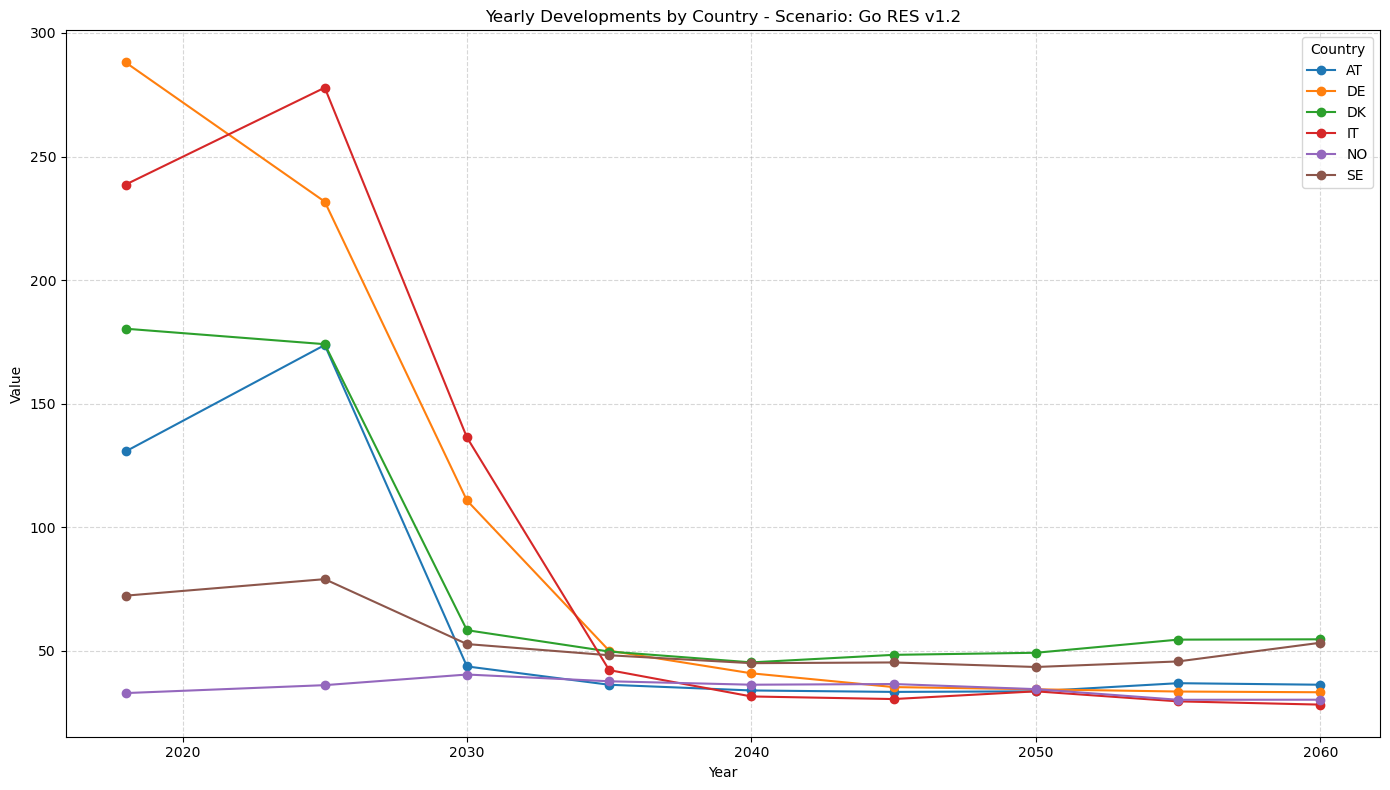

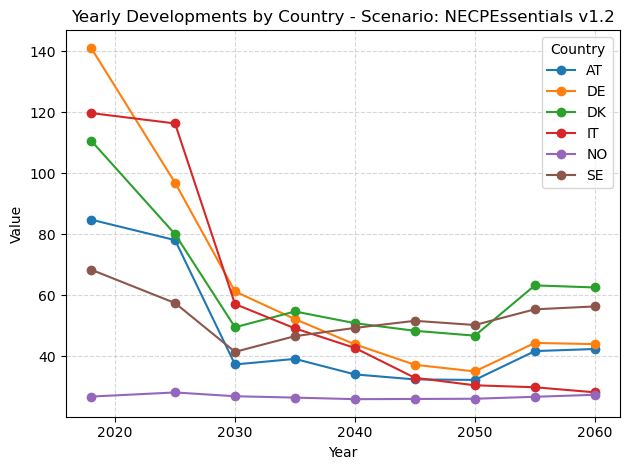

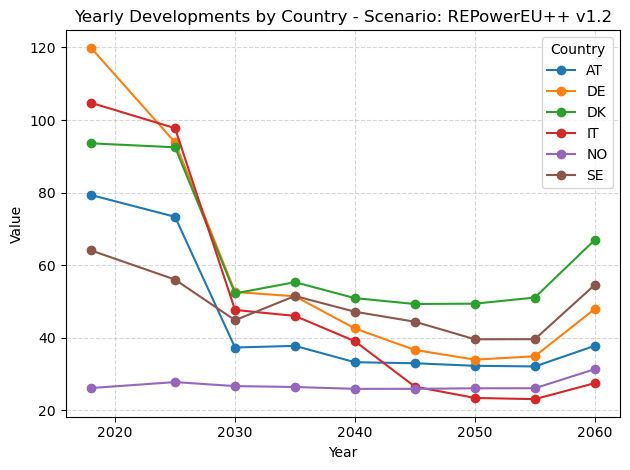

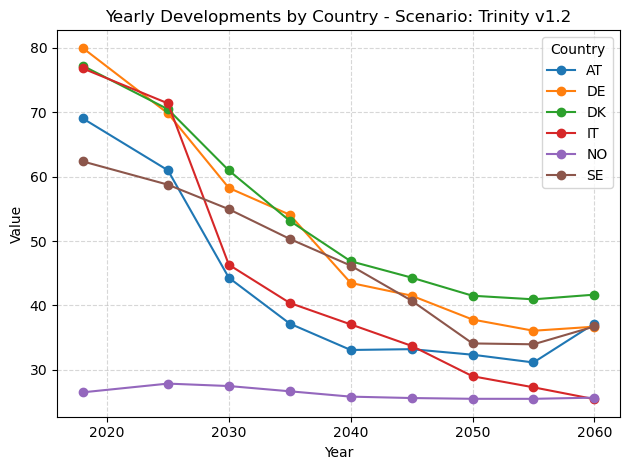

In [60]:
import matplotlib.pyplot as plt

scenarios = filtered_excel['Model Version'].unique()
countries = filtered_excel['Region'].unique()
years = sorted(filtered_excel['Year'].unique())

plt.figure(figsize=(14, 8))

for scenario in scenarios:
    for country in countries:
        df = filtered_excel[(filtered_excel['Model Version'] == scenario) & (filtered_excel['Region'] == country) & (filtered_excel['Unit'] == "Fuel Costs in EUR/MWh")]
        if not df.empty:
            df_sorted = df.sort_values('Year')
            plt.plot(df_sorted['Year'], df_sorted['Value '], marker='o', label=country)
    plt.title(f"Yearly Developments by Country - Scenario: {scenario}")
    plt.xlabel("Year")
    plt.ylabel("Value")
    plt.legend(title="Country")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


In [61]:
# creating location dependent costs for fuel 
# TODO: matching the electricity costs with ETIS nodes 
# electricity 

av_electricity_tax = filtered_conn_costs["CostElectricityT"].mean()


avg_elec_prices_per_year = elec_prices.groupby("year")["elec_price_EURperkWh"].mean().reset_index()
av_elec_price_dict = dict(zip([int(year) for year in avg_elec_prices_per_year["year"].to_list()], avg_elec_prices_per_year["elec_price_EURperkWh"].to_list()))
av_all_elec_prices = extrapolate_years(av_elec_price_dict, range(y_init, y_init + Y))
av_electricity_prices = [float(av_all_elec_prices[y] + av_electricity_tax) for y in range(y_init, y_init + Y)]
fc_id = 0
fuel_cost_list = []
fuel_list = []
for geo in geographic_elements:
    etis_node_id = geo["name"]
    extract_df = filtered_network_nodes[filtered_network_nodes['ETISplus_Zone_ID'] == etis_node_id]
    country_code = extract_df["Country"].to_list()[0]
    extract_elec_prices = elec_prices[elec_prices['NUTS_region'] == country_code]
    elec_price_dict = dict(zip([int(item) for item in extract_elec_prices["year"].to_list()], extract_elec_prices["elec_price_EURperkWh"].to_list()))
    all_elec_prices = extrapolate_years(elec_price_dict, range(y_init, y_init + Y))
    electricity_prices = [float(all_elec_prices[y] + av_electricity_tax) for y in range(y_init, y_init + Y)]
    if case in [1, 2]:
        fuel_cost_list.append({
            "id": fc_id,
            "location": geo["id"],
            "fuel": "electricity",
            "cost_per_kWh": av_electricity_prices,
        })
        fc_id += 1
    else:
        fuel_cost_list.append({
            "id": fc_id,
            "location": geo["id"],
            "fuel": "electricity",
            "cost_per_kWh": electricity_prices,
        })
        fc_id += 1
    fuel_cost_list.append({
        "id": fc_id,
        "location": geo["id"],
        "fuel": "diesel",
        "cost_per_kWh": [0.065] * Y,  # Assuming a constant diesel price for simplicity
    })
    fc_id += 1

    

In [62]:
fuel_list = [{
    "id": 0,
    "name": "electricity",
    "emission_factor": [0.0] * Y,  # kg CO2e/kWh
    "cost_per_kWh": [0.0] * Y,  # EUR/kWh
    "cost_per_kW": [0.0] * Y,  # EUR/kW
    "fueling_infrastructure_om_costs": [0.0] * Y,  # EUR/kW/year
},
{
    "id": 1,
    "name": "diesel",
    "emission_factor": [0.0] * Y,  # kg CO2e/kWh
    "cost_per_kWh": [0.0] * Y,  # EUR/kWh
    "cost_per_kW": [0.0] * Y,  # EUR/kW
    "fueling_infrastructure_om_costs": [0.0] * Y,  # EUR/kW/year
}]

In [63]:
# geographically varying network costs

annually_charged_energy = filtered_conn_costs["ChargingEnergy"].mean()
av_network_cost = filtered_conn_costs["CostElectricityN"].mean() * annually_charged_energy / reference_cap  
network_cost_list = []
nc_id = 0
costs_by_country = {}
for geo in geographic_elements:
    country_code = filtered_network_nodes[filtered_network_nodes['ETISplus_Zone_ID'] == geo["name"]]['Country'].values[0]
    extract_df = filtered_conn_costs[filtered_conn_costs['Code'] == country_code]

    network_cost_value = extract_df["CostElectricityN"].values[0] * annually_charged_energy / reference_cap   # €/kW 
    if case in [1, 3]:
        network_cost_list.append({
            "id": nc_id,
            "name": geo["id"],
            "network_cost_per_kW": [float(av_network_cost)] * Y,  # Assuming constant network cost per kW for simplicity
        })
    else:
        network_cost_list.append({
        "id": nc_id,
        "name": geo["id"],
        "network_cost_per_kW": [float(network_cost_value)] * Y,  # Assuming constant network cost per kW for simplicity
        })
    costs_by_country[country_code] = network_cost_value


    nc_id += 1



In [64]:
import yaml

data = {
    "TechVehicle": tech_vehicle_list,
    "GeographicElement": geographic_elements,
    "FinancialStatus": financial_status_list,
    "Vehicletype": vehicle_type_list,
    "Mode": mode_list,
    "Technology": [{
        "id": 0, 
        "name": "ICEV",	
        "fuel": "diesel",
    }, {
        "id": 1, 
        "name": "BEV",	
        "fuel": "electricity",
    }],
    "Speed": speed_list,
    "Regiontype": region_list,
    "InitialModeInfr": initialmodeinfr,
    "InitialFuelInfr": initialfuelinfr,
    "Odpair": odpair_list,
    "Path": path_list,
    "Fuel": fuel_list,
    "FuelCost": fuel_cost_list,
    "FuelingInfrTypes": charging_types_list,
    "InitialVehicleStock": initial_vehicle_stock,
    "NetworkConnectionCosts": network_cost_list,
    "Product": [{"id": 0, "name": "freight"}],
    "Model": {"Y": Y, "pre_y": 25, "y_init": y_init, "gamma": 0.05, "budget_penalty_plus": 10000, "budget_penalty_minus": 10000, "discount_rate": 0.05, "investment_period": 5, "budget_penalty_yearly_plus": 10000, "budget_penalty_yearly_minus": 10000},
}

In [65]:
# Create output directory if it doesn't exist


# saving as YAML
import time 
start_time = time.time()
with open("input_data/MOVELOADS_test_input.yaml", "w") as file:
    yaml.dump(data, file, default_flow_style=False)


print(time.time() - start_time, " seconds")

18.591844081878662  seconds
